# Chebyshev differentiation matrix

Say we are given a grid function $v$ on the Chebyshev points

$$
x_j = \cos\left( \frac{j\pi}{N} \right), \qquad j=0,\ldots,N. 
$$

```{caution}
The definition above orders the Chebyshev points from right to left, which can cause confusion. Note also that there are $N+1$ of them when we refer to degree $N$ interpolants.
```

The Chebyshev spectral collocation scheme is:

1. Let $p$ be the unique polynomial of degree no more than $N$ interpolating $v$ at the $x_j$. 
2. Set $w_j=p'(x_j)$ for all $j$.

The process is linear, so there is a matrix $\bfD_N$ such that

$$
\bfw = \bfD_N \bfv. 
$$

```{note}
The restriction to even $N$ for our Fourier formulas does not apply to the Chebyshev formulas we present.
```

Unlike the Fourier case, we do not have translation invariance along the Chebyshev grid, so more than one column of $\bfD_N$ has to be worked out.

::::{prf:example}
For $N=2$, we have $x_0=1$, $x_1=0$, and $x_2=-1$, and we can write 

$$
p(x) &= \frac{(x)(x+1)}{(1)(1+1)}v_0 + \frac{(x-1)(x+1)}{(-1)(+1)}v_1 + \frac{(x-1)(x)}{(-1-1)(-1)}v_2 \\ 
&= \frac{1}{2}(x^2+x)v_0 + (1-x^2)v_1 + \frac{1}{2}(x^2-x)v_2. 
$$

Thus,

$$
p'(x) = \frac{1}{2}(2x+1)v_0 -2x v_1 + \frac{1}{2}(2x-1)v_2, 
$$

and we get

$$
\bfD_2 = \begin{bmatrix}
  \tfrac{3}{2} & -2 & \tfrac{1}{2} \\ 
  \tfrac{1}{2} & 0 & -\tfrac{1}{2} \\ 
  -\tfrac{1}{2} & 2 & -\tfrac{3}{2}
\end{bmatrix}. 
$$

We have seen these rows of numbers occur before, since they arise from finite differences on 3 equally spaced points.
::::

Formulas for the entries of $\bfD_N$ in the general case are given in the textbook on p. 53. Here is a code that implements them:

In [1]:
using Sugar, SpectralMethodsTrefethen
Sugar.get_source(first(methods(cheb))) |> last |> print

function cheb(N)
    N==0 && return 0,1;
    x = [ cos(pi*k/N) for k=0:N ];
    c = [2;ones(N-1);2] .* (-1).^(0:N);
    dX = x .- x';
    D  = (c*(1.0./c)') ./ (dX+I(N+1));      # off-diagonal entries
    D  = D - diagm(vec(sum(D,dims=2)));    # diagonal entries
    return D,x
end

The code above does not use formulas for the diagonal entries. Instead, it uses the *negative sum trick*, which arises from the fact that the derivative of a constant function is exactly zero in a spectral method, and rewrites the condition $\sum_j (D_N){ij} = 0$ as an equation for the diagonal term.

Note that the differentiation matrix does have the antisymmetry property

$$
(D_N){N-i,N-j} = -(D_N)_{i,j}. 
$$

Otherwise, the matrices do not have much obvious structure:

In [2]:
D, _ = cheb(4)
D

5×5 Matrix{Float64}:
  5.5       -6.82843    2.0      -1.17157    0.5
  1.70711   -0.707107  -1.41421   0.707107  -0.292893
 -0.5        1.41421    0.0      -1.41421    0.5
  0.292893  -0.707107   1.41421   0.707107  -1.70711
 -0.5        1.17157   -2.0       6.82843   -5.5

In [3]:
D, _ = cheb(5)
D

6×6 Matrix{Float64}:
  8.5       -10.4721     2.89443   -1.52786    1.10557   -0.5
  2.61803    -1.17082   -2.0        0.894427  -0.618034   0.276393
 -0.723607    2.0       -0.17082   -1.61803    0.894427  -0.381966
  0.381966   -0.894427   1.61803    0.17082   -2.0        0.723607
 -0.276393    0.618034  -0.894427   2.0        1.17082   -2.61803
  0.5        -1.10557    1.52786   -2.89443   10.4721    -8.5

For the analytic, nonperiodic function $e^x\sin(5x)$, the spectral derivative has about 2 accurate digits at $N=10$ and 9 at $N=20$:

function p11()
    u = x -> exp(x) * sin(5x) 
    uʹ = x -> exp(x) * (sin(5x) + 5 * cos(5x))
    xx = (-200:200) / 200
    vv = @. u.(xx)
    fig = Figure()
    for (i,N) in enumerate([10, 20])
        D, x = cheb(N)
        v = u.(x)
        Axis(fig[i, 1], title="u(x),  N=$N")
        scatter!(x, v)
        lines!(xx, vv)
        error = D * v - uʹ.(x)
        Axis(fig[i, 2], title="error in uʹ(x),  N=$N")
        scatter!(x, error)
        lines!(xx, polyinterp(x, error).(xx))
    end
    return fig
end

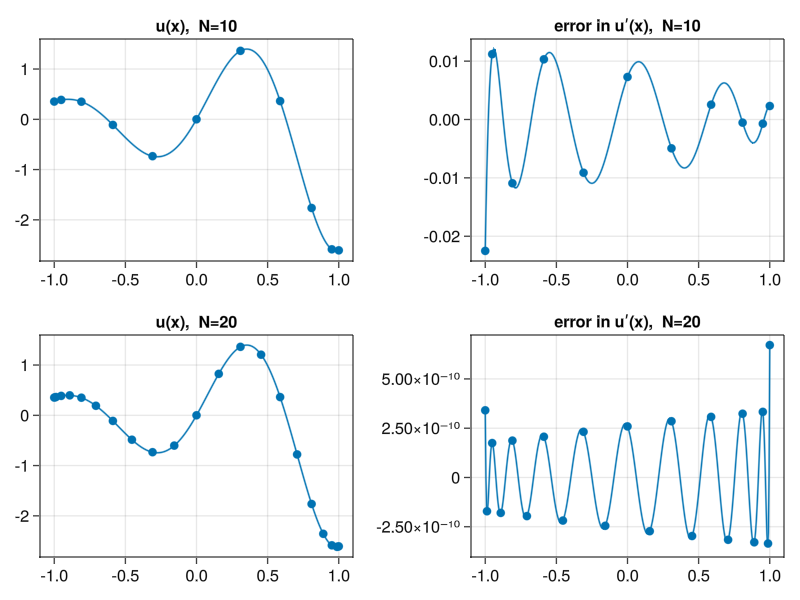

In [4]:
Sugar.get_source(first(methods(p11))) |> last |> print
p11()

The effects of smoothness are illustrated more clearly here:

function p12(Nmax = 50)
    # Compute derivatives for various values of N:
    data = [ 
        # uʹʹʹ in BV
        (x -> abs(x)^3,  x -> 3x * abs(x), L"|x|^3", (1,1)), 
        # C-infinity
        (x -> exp(-x^(-2)), x -> 2exp(-x^(-2)) / x^3, L"\exp(-x^{-2})", (1,2)), 
        # analytic in [-1,1]
        (x -> 1 / (1 + x^2), x -> -2x / (1 + x^2)^2, L"1/(1+x^2)", (2,1) ),
        # polynomial 
        (x -> x^10, x -> 10x^9,  L"x^{10}", (2,2))
    ]
    fig = Figure()
    E = zeros(Nmax)
    ax = []
    for (u,uʹ,title,pos) in data
        for N in 1:Nmax
            D, x = cheb(N)
            E[N] = norm(D * u.(x) - uʹ.(x), Inf)
        end
        push!(
            ax,
            Axis(fig[pos[1], pos[2]];title, yscale=log10)
        )
        scatterlines!(1:Nmax, E)
        (pos[1] == 2) && (ax[end].xlabel = "N")
        (pos[2] == 1) && (ax[end].ylabel = "error")
    end
    linkxaxes!(ax...)
    linkyaxes!(ax...)
    return fig
end

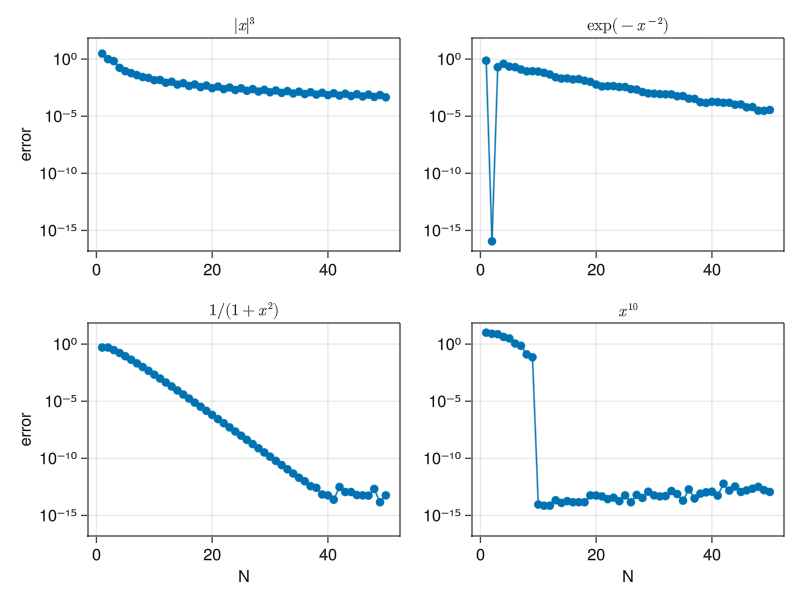

In [5]:
Sugar.get_source(first(methods(p12))) |> last |> print
p12()

The function $|x|^3$ has only 2 continuous derivatives, so the convergence is algebraic. Next, $e^{-x^2}$ is not analytic, and its convergence is between algebraic and exponential. The case $1/(1+x^2)$ is analytic around the interval, showing spectral convergence, and the function $x^{10}$ is the polynomial analog of "band-limited."